In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE

import os
from scipy import stats as scs
os.chdir('../')
from src.modeling import *
os.chdir('notebooks')

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
import warnings 
warnings.simplefilter('ignore')


# Important notes:

- N2 (number of exemptions) represents the population
- N1 represents number of households 
- A00100 represents AGI
- N00200 represents number of returns with salaries and wages
- A00200 represents the amount of salaries and wages

[source](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi)

From data_dictionary:

 - N02650	Number of returns with total income
 - A02650	Total income amount

## Importing the data

In [2]:
# Should be dropped when predicting number of playgrounds as Y variable ( data leakage)
columns_from_playgrounds_dataset = ['Accessible', 'Adaptive_Swing', 'School', 'Status_closed',
       'Status_open to the public', 'Status_two playgrounds', 'Status_weekdays', 
        'Status_weekends', 'Level_1.0', 'Level_2.0', 'Level_3.0', 'Level_4.0']
# It might be interesting to predict playground availability as playground_count*hours_open in a later iteration
# since some of these playgrounds double as schoolyards, some are only open on weekends/weekdays/etc

In [3]:
df = pd.read_csv('../data/nyc_playgrounds.csv', index_col='zipcode')
df.fillna(0, inplace=True)
df.head()

,Accessible,Adaptive_Swing,School,Status_closed,Status_open to the public,Status_two playgrounds,Status_weekdays,Status_weekends,Level_1.0,Level_2.0,Level_3.0,Level_4.0,playground_count,POPULATION,AREA,geometry,N1,mars1,MARS2,MARS4,PREP,N2,NUMDEP,TOTAL_VITA,VITA,TCE,VITA_EIC,RAL,RAC,ELDERLY,A00100,N02650,A02650,N00200,A00200,N00300,A00300,N00600,A00600,N00650,A00650,N00700,A00700,N00900,A00900,N01000,A01000,N01400,A01400,N01700,...,A07100,N07300,A07300,N07180,A07180,N07230,A07230,N07240,A07240,N07220,A07220,N07260,A07260,N09400,A09400,N85770,A85770,N85775,A85775,N09750,A09750,N10600,A10600,N59660,A59660,N59720,A59720,N11070,A11070,N10960,A10960,N11560,A11560,N06500,A06500,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902,borough_name,Borough_M,Borough_Q,Borough_R,Borough_X
zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,22413.0,1.779494e+07,POLYGON ((-74.00827017706987 40.75258680959698...,14520,10450,2540,1120,8790,19960,3290,350,160,190,60,40,1230,2560,2291296,14520,2323084,12080,1618969,5580,25849,4820,58288,4550,44542,3350,14915,2980,82477,4470,192534,1080,19430,1610,...,14647,2130,11613,290,185,520,585,330,59,540,521,0,0,2500,14882,160,372,200,378,470,391,13490,558829,1470,2406,1100,1937,520,611,420,377,80,75,11710,497478,12470,524842,1980,6213,1680,7081,3680,40079,9600,51137,M,1,0,0,0
10002,22.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,1.0,10.0,23.0,81305.0,2.628013e+07,"POLYGON ((-73.97441674502171 40.736424085467, ...",42180,25270,10500,5630,28170,68970,17490,1200,920,290,330,180,3550,7680,2281527,42180,2313723,35240,1802797,9370,12873,7160,35706,6740,27472,4580,8771,7690,113416,6110,103413,1690,21212,3850,...,8395,2120,2384,1190,689,1310,1349,1270,293,2770,2636,40,22,7100,18294,400,1016,490,1096,2120,1457,37750,413475,13310,25712,10900,22616,5270,6870,1290,1117,200,194,24850,331192,29030,356377,1280,2110,1070,2964,9000,35096,30040,81377,M,1,0,0,0
10003,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,55878.0,1.553838e+07,POLYGON ((-73.97986374206835 40.73497413255052...,28660,21830,5340,870,18300,37530,4490,260,160,100,40,0,1650,5600,6622842,28660,6720746,23400,3965359,14260,159535,13820,310557,13290,195597,8110,50692,6710,261633,12880,931151,2950,69188,3230,...,51466,6720,46054,510,311,730,889,390,76,470,463,40,89,6010,42740,280,671,380,677,700,602,26920,1670731,1240,1269,740,904,300,326,450,411,160,213,24940,1484489,26030,1566958,5110,18272,4730,30671,8100,105180,17200,133151,M,1,0,0,0
10007,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,7323.0,5.327871e+06,"POLYGON ((-74.0133873791513 40.71743717586856,...",3440,2010,1190,120,2560,5940,1460,0,0,0,0,0,130,460,3023883,3440,3048670,2870,1159584,2110,75838,2070,280063,2000,85088,1240,24035,690,61526,1960,208492,240,6952,250,...,22062,1110,20092,170,104,80,100,40,6,80,85,0,0,720,10851,0,0,30,36,40,48,3210,830886,90,125,60,92,30,39,50,40,0,0,3080,741039,3180,767641,1400,8020,1240,19184,1170,28665,1730,67189,M,1,0,0,0
10009,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,7.0,61455.0,1.590352e+07,POLYGON ((-73.97345725849812 40.73070754108718...,32410,23180,5060,3470,17760,45420,9120,990,800,180,320,140,3620,5930,2574118,32410,2611193,27440,2027939,9630,11140,8280,42516,7850,31583,5460,11971,6160,107092,7280,109359,2160,32684,3940,...,8142,2910,2383,770,455,1370,1575,840,163,1710,1700,30,19,5100,17238,330,700,440,804,980,730,30610,501106,4520,8898,3550,7336,1960,2303,1040,936,150,161,25470,426753,27250,450366,1650,2675,1320,4035,7040,36988,23570,66621,M,1,0,0,0


In [4]:
# NY population was estimated to be 8.615m (google). this is pretty close
print('population estimate: {}'.format(df['N2'].sum()))
print('household estimate: {}'.format(df['N1'].sum()))

population estimate: 7294130
household estimate: 4091960


In [5]:
df['playground_count'].sum()

1253.0

## Population vs. N2 count

According to [source](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi) the N2 count is supposed to be a close representation of the total population. The N2 column should be preferred over the POPULATION column as the Population column is from a different 2014 dataset, and the parks and tax returns data is 2016 data. It is, however a good data check


In [6]:
print('There is a {}% difference in the population counts'.format(
    round((df['POPULATION'].sum() - df['N2'].sum())
      /df['POPULATION'].sum()*100,2)))

There is a 10.37% difference in the population counts


In [7]:
df.drop('POPULATION', axis=1, inplace=True)

# Feature engineering: creating new measures

After observing the data dictionary, these are some interesting features I decided to create. Will investifate them further throughout this notebook

In [8]:
df['mean_household_agi'] = df.A00100 / df.N1
df['mean_household_income'] = df.A02650 / df.N1
df['mean_wages_per_person'] = df.A00200 / df.N00200
sqft_sqmi_conversion = 3.58701e-8
df['AREA'] *= sqft_sqmi_conversion
df['population_density'] = (df['N2']/df['AREA'])
df['household_density'] = (df['N1']/df['AREA'])

In [9]:
# These lists will be useful for quick operations later
y_cols = ['playground_count']

object_type_columns = ['borough_name', 'geometry']

## Feature Reduction 

In [10]:
# consolidates the amount and number columns for each tax code
# Ex: A00200 (amount) and N00200 (count) become mean_00200
df_original = df.copy()
df = consolidate_tax_codes(df) 

#### Number of Households and Population are collinear (makes sense)
Since I am more interested in household income, I should keep N1. I created a few features using N2 and should drop those from my dataset

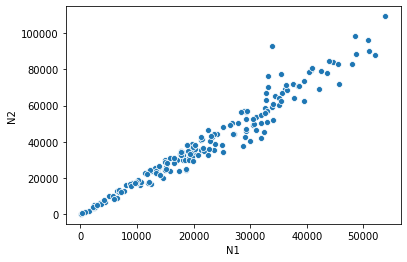

In [11]:
sns.scatterplot(df.N1, df.N2)

In [12]:
# Dropping the engineered features that incorporate N2
df.drop(['population_density', 'N2'],
        axis=1,inplace=True)

In [13]:
def check_collinear_features(df, col, threshold):
    correlations = df.corr()[col]
    return correlations[correlations > threshold]

In [14]:
check_collinear_features(df, 'mean_household_income', 0.8)

mean_household_agi       0.999993
mean_household_income    1.000000
mean_wages_per_person    0.954732
mean_02650               1.000000
mean_00200               0.954732
mean_00600               0.889495
mean_00650               0.820699
mean_00700               0.946821
mean_00900               0.891556
mean_01000               0.876152
mean_02900               0.963714
mean_04470               0.938025
mean_18425               0.976332
mean_18500               0.918155
mean_18300               0.975660
mean_20800               0.803658
mean_04800               0.996848
mean_05800               0.994897
mean_09600               0.875197
mean_07100               0.861183
mean_07300               0.824982
mean_09400               0.922296
mean_10600               0.990298
mean_06500               0.993854
mean_10300               0.994622
mean_85530               0.833496
mean_85300               0.800616
mean_11901               0.932571
mean_11902               0.913833
Name: mean_hou

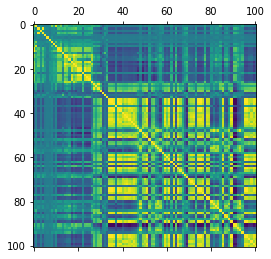

In [15]:
plt.matshow(df.corr())

That's a lot of multicollinearity. I'll have to keep this in mind as I go

### Normalizing Income by borough

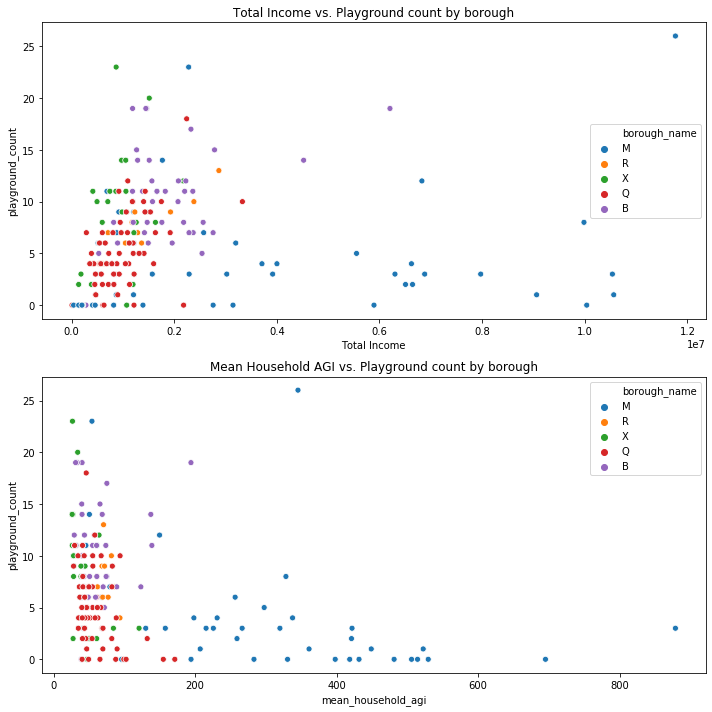

In [16]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
# A00100 is total income
sns.scatterplot(df['A00100'], df.playground_count, hue=df['borough_name'], ax=ax[0])
ax[0].set_title('Total Income vs. Playground count by borough')
ax[0].set_xlabel('Total Income')
# Note mean_household_agi is a function of A00100
sns.scatterplot(df['mean_household_agi'], df.playground_count, 
              hue=df['borough_name'], ax=ax[1])
ax[1].set_title('Mean Household AGI vs. Playground count by borough')

plt.tight_layout()

It looks like theres a difference in distribution of AGI by borough. It might be useful to normalize the A00100 with the mean A00100 per borough and normalize the mean household AGI with the mean household AGI of each borough

In [17]:
def create_borough_mean_AGI(df):
    borough_mean_agi = (df.groupby('borough_name').mean()['A00100']).reset_index()
    borough_mean_agi.columns = ['borough_name', 'borough_mean_agi']
    df2 = pd.merge(df.reset_index(), borough_mean_agi, on='borough_name')
    return df2.set_index('zipcode')

def create_borough_mean_household_AGI(df):
    borough_mean_agi = (df.groupby('borough_name').sum()['A00100']\
        / df.groupby('borough_name').sum()['N1']).reset_index()
    borough_mean_agi.columns = ['borough_name', 'borough_mean_household_agi']
    df2 = pd.merge(df.reset_index(), borough_mean_agi, on='borough_name')
    return df2.set_index('zipcode')



In [18]:
df = create_borough_mean_household_AGI(df)
df = create_borough_mean_AGI(df)

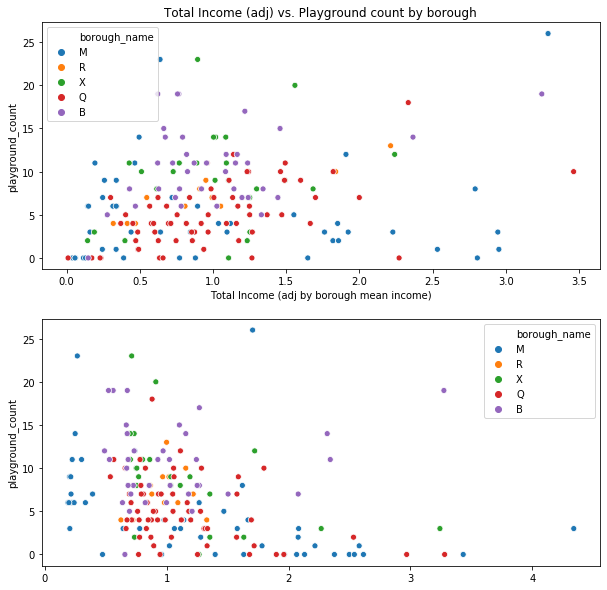

In [19]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.scatterplot(df.A00100/df.borough_mean_agi, df.playground_count, hue=df['borough_name'], ax=ax[0])

ax[0].set_title('Total Income (adj) vs. Playground count by borough')
ax[0].set_xlabel('Total Income (adj by borough mean income)')

sns.scatterplot(df.mean_household_agi/df.borough_mean_household_agi, df.playground_count, hue=df['borough_name'], ax=ax[1])

In [20]:
df['normalized_A00100'] = df.A00100/df.borough_mean_agi
df['normalized_mean_household_agi'] = df.mean_household_agi/df.borough_mean_household_agi

# Fitting Models to the Data

In [21]:
RANDOM_STATE = 15

y = df['playground_count']
X = df.drop(['playground_count', 'geometry', 'borough_name'] + columns_from_playgrounds_dataset,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

I am going to use `Mean Absolute Error` as the main scoring parameter, since it is very interpretable, and the number of playgrounds is on such a small scale. 

Cross validation (k folds = 10) on the training set will be used to compare these models against eachother.

In [22]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

def MAE(y_pred, y_test):
    return np.mean(np.abs(y_test-y_pred))

# Backward Selection

I am going to try out __Backward Selection__ a Recursive Feature Elimination strategy. While this is a common practice, it is import to note that it can introduce bias

The RFE object will chose the top 20 most important features found in the training set. Considering there is so much multicollinearity, its entirely possible it will have a difficult time finding the best features

In [23]:
rfe = RFE(LinearRegression(normalize=True), 20)
cv_score = (cross_val_score(rfe, X_train, y_train, cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
cv_score

3.6995187151745577

Its important to know how this compares to using just the average value of playground count as a predictor

In [24]:
MAE(pd.Series([y_train.mean()]*len(y_test), index=y_test.index), y_test)

4.161450924608818

The good news is it beats the baseline Mean Absolute Error of 4.16

## Making predictions on the holdout set

In [25]:
rfe = RFE(LinearRegression(normalize=True), 20)
rfe.fit(X_train,y_train)
rfe_columns = X_train.columns[rfe.support_]

In [26]:
ypreds = rfe.predict(X_test)
print('Mean Absolute Error on holdout set:', round(MAE(y_test, ypreds),2))

print('r2 score:', round(r2_score(y_test, ypreds),2))

Mean Absolute Error on holdout set: 3.16
r2 score: 0.38


Not a bad approach all things considered.

# Regularized Regression

# Testing out of box Ridge and Lasso Regression models


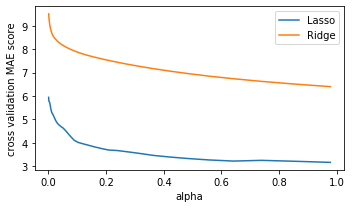

In [27]:
alphas = np.logspace(-3, -0.01, 50)
plt.figure(figsize=(5, 3))


for Model in [Lasso, Ridge]:
    scores = [(cross_val_score(Model(alpha), X_train, y_train, cv=10, 
                scoring = 'neg_mean_absolute_error')*-1).mean() for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend()
plt.xlabel('alpha')
plt.ylabel('cross validation MAE score')
plt.tight_layout()
plt.show()

Not the worst out of box model scores. It makes sense that the lasso is outperforming the ridge regression since there are so many multicollinear features. The lasso model can set the coefficients of some of these redundant features to zero.

### Scoring Ridge Regression

In [28]:
clf = make_pipeline(StandardScaler(), Ridge(1))
cv_score = (cross_val_score(clf, X_train, y_train, cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
print('Cross Val MAE', round(cv_score,2))


clf.fit(X_train, y_train)
print('Ridge regression MAE on test set: {}'.format(
    MAE(clf.predict(X_test),y_test)))

print('Ridge regression R^2 on test set: {}'.format(
    clf.score(X_test,y_test)))

Cross Val MAE 4.49
Ridge regression MAE on test set: 3.2596469880164456
Ridge regression R^2 on test set: 0.19425455250667878


### Scoring Lasso Regression

In [29]:
from sklearn.pipeline import make_pipeline
lasso_clf = make_pipeline(StandardScaler(), Lasso(0.6))
lasso_cv_score = (cross_val_score(lasso_clf, X_train, y_train, 
            cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
print('Cross Val MAE', round(lasso_cv_score,2))


lasso_clf.fit(X_train, y_train)

print('Lasso regression MAE on test set: {}'.format(
    MAE(lasso_clf.predict(X_test),y_test)))

print('Lasso regression R^2 on test set: {}'.format(
    lasso_clf.score(X_test,y_test)))

Cross Val MAE 2.4
Lasso regression MAE on test set: 2.399074668336554
Lasso regression R^2 on test set: 0.6310771244831324


The lasso looks like an excellent model. The most important features determined by the lasso are below, however this certainly could have been skewed by multicollinearity

In [30]:
significant_features = np.nonzero(lasso_clf['lasso'].coef_)[0]
coefs = lasso_clf['lasso'].coef_[significant_features]
features = X_train.iloc[:,significant_features]
features

,AREA,N1,mars1,RAL,mean_59720
zipcode,,,,,
10034,0.878957,20140,11700,90,2.375876
11697,2.144665,2210,1160,0,0.866667
10011,0.649909,29920,22080,20,1.594792
11364,3.022403,17800,8260,0,2.117544
11106,0.856080,21880,13890,80,2.062411
...,...,...,...,...,...
11209,2.074810,34110,18740,80,2.160358
11426,1.779486,9130,4250,0,1.979167
11414,2.293133,13320,6630,60,2.014167


In [31]:
pd.DataFrame(zip(features.columns, coefs), columns = ['Features', 'Lasso Coefs']).set_index('Features')

,Lasso Coefs
Features,
AREA,0.039205
N1,1.623180
mars1,0.375497
RAL,1.466086
mean_59720,0.571292


Investigating Zip code 10475 

 - N1: number of returns
 - AREA: area of zipcode
 - MARS1: Number of Single Returns 
 - RAL: Number of refund anticipation loan returns
 - 59720: returns with excess earned income credit

## Elastic Net

Elastic Net is a mix between the regularization terms of both Ridge Regression and Lasso Regression, and tends to be preferred to Lasso regression especially when the number of features is close to or greater than the number of observations, or when there is a lot of multicollinearity. This seems like a fantastic use case.

Elastic net's mix between Ridge and Lasso regularization is controlled by the parameter `r` where `r=0` is simply Ridge regression and `r=1` is simply Lasso regression. The cost function is below:

$$
J(\theta) = MSE(\theta) + r\alpha \sum |\theta_i| + \frac{1-r}{2}\alpha \sum \theta^2_i
$$

In [32]:
from sklearn.linear_model import ElasticNet

In [33]:
EN = make_pipeline(StandardScaler(), ElasticNet(0.5))
EN_score = (cross_val_score(EN, X_train, y_train, 
            cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
print('Cross Val MAE', round(EN_score,2))

EN.fit(X_train, y_train)

print('Elastic Net regression MAE on test set: {}'.format(
    MAE(EN.predict(X_test),y_test)))

print('Elastic Net R^2 on test set: {}'.format(
    EN.score(X_test,y_test)))

Cross Val MAE 2.39
Elastic Net regression MAE on test set: 2.317100558916847
Elastic Net R^2 on test set: 0.6647855200615902


In [34]:
EN_significant_features = np.nonzero(EN['elasticnet'].coef_)[0]
coefs = EN['elasticnet'].coef_[EN_significant_features]
features = X_train.iloc[:,EN_significant_features]
print(features.columns)

Index(['AREA', 'N1', 'mars1', 'MARS2', 'PREP', 'NUMDEP', 'TOTAL_VITA', 'VITA',
       'VITA_EIC', 'RAL', 'RAC', 'SCHF', 'Borough_Q', 'mean_18800',
       'mean_19550', 'mean_07260', 'mean_59660', 'mean_59720', 'mean_11560',
       'normalized_A00100'],
      dtype='object')


## Ensemble Learning

Random Forests and Gradient Boosting are interesting because they are really good at reducing both bias and variance. While it's a small dataset, I'm interested to see how these 2 models perform

In [35]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [36]:
RF = make_pipeline(StandardScaler(), RandomForestRegressor())
RF_score = (cross_val_score(RF, X_train, y_train, 
            cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
print('Cross Val MAE', round(RF_score,2))

RF.fit(X_train, y_train)

print('Random Forest regression MAE on test set: {}'.format(
    MAE(RF.predict(X_test),y_test)))

print('Random Forest regression R^2 on test set: {}'.format(
    RF.score(X_test,y_test)))



Cross Val MAE 2.42
Random Forest regression MAE on test set: 2.1973684210526314
Random Forest regression R^2 on test set: 0.6798504725400123


In [37]:
GB = make_pipeline(StandardScaler(), GradientBoostingRegressor())
GB_score = (cross_val_score(GB, X_train, y_train, 
            cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
print('Cross Val MAE', round(GB_score,2))

GB.fit(X_train, y_train)

print('Gradient Boosting regression MAE on test set: {}'.format(
    MAE(GB.predict(X_test),y_test)))

print('Gradient Boosting regression R^2 on test set: {}'.format(
    GB.score(X_test,y_test)))

Cross Val MAE 2.38
Gradient Boosting regression MAE on test set: 2.2376159117669525
Gradient Boosting regression R^2 on test set: 0.6871816230426648


Really impressed with the Gradient Boosting model and the Elastic Net model given I have such messy data, so few data points, and so many uninformative features

# Next steps:
 - Visualize the individual relations of these features
 - Reduce multicollinearity
 - Create a second model to predict if zipcodes have greater than zero parks
 - Test out sklearns n-best features package
 - Identify the zipcodes that _should_ have more playgrounds, but do not. These could be areas that are in need of playgrounds!

### Predicting Neighborhoods with Zero playgrounds

Text(0.5, 1.0, 'Playground count per zip code (log transform)')

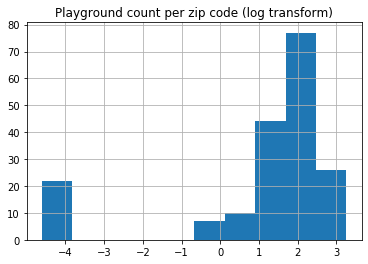

In [38]:
np.log(pd.concat((y_test, y_train))+0.01).hist()
plt.title('Playground count per zip code (log transform)')

As shown there's a decent amount of zip codes with zero playgrounds - predicting which zip codes have zero playgrounds could help the predictive power of this model quite a bit. The low amount of data points might make this a challenge though.

In [39]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

Are there enough data points?

In [40]:
(y_train == 0).sum(), (y_test == 0).sum()

(16, 6)

This might be a little low to be predicting. Will attempt anyway to explore the idea

In [41]:
binary_y_train = (y_train == 0)*1
binary_y_test = (y_test == 0)*1

In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
RFC = make_pipeline(StandardScaler(), RandomForestClassifier())

cv = cross_val_score(RFC, X_train, binary_y_train, 
                     cv=10, scoring='roc_auc').mean()

print('RF classifier ROC AUC score on training set: {}'.format(cv))

RFC.fit(X_train, binary_y_train)
print('ROC AUC Score on test set: {}'.format(
    roc_auc_score(RFC.predict(X_test),binary_y_test)))



RF classifier ROC AUC score on training set: 0.9192307692307693
ROC AUC Score on test set: 0.9571428571428571


In [44]:
GBC = make_pipeline(StandardScaler(), GradientBoostingClassifier())

cv = cross_val_score(GBC, X_train, binary_y_train, 
                     cv=10, scoring='roc_auc').mean()

print('GB classifier ROC AUC score on training set: {}'.format(cv))

GBC.fit(X_train, binary_y_train)

print('ROC AUC Score on test set: {}'.format(
    roc_auc_score(GBC.predict(X_test),binary_y_test)))


GB classifier ROC AUC score on training set: 0.873076923076923
ROC AUC Score on test set: 0.9444444444444444


In [45]:
class custom_ensemble:
    
    def __init__(self, r=0.5, thresh=0.8):
        self.thresh = thresh
        self.GBC = make_pipeline(StandardScaler(), GradientBoostingClassifier())
        self.ENR = make_pipeline(StandardScaler(), ElasticNet(r))

    def fit(self, X_train, y_train):
        binary_y_train = (y_train != 0)*1
        self.GBC.fit(X_train, binary_y_train)
        self.ENR.fit(X_train, y_train)
    
    def predict(self, X_test):
        ypredC = (self.GBC.predict_proba(X_test)[:,1] > self.thresh)*1
        ypredR = self.ENR.predict(X_test)
        res = np.c_[ypredC, ypredR]
        return res[:,0]*res[:,1]
    
    def score(self, X_test, y_test):
        '''Uses MAE'''
        binary_y_test = (y_test == 0)*1
        yhat = self.predict(X_test)
        return MAE(yhat, y_test)

In [46]:
CE = custom_ensemble(0.5)

CE.fit(X_train, y_train)
CE.score(X_test, y_test)

2.2472837713913294

I just don't feel too confident in this approach due to the low amount of zero values. It could be interesting to try and develop this approach further and optimize it by looking at an ROC curve and precision-recall curve. If the model was to have a false positive rate of 0 and was still able to predict just a few zipcodes with zero playgrounds, it could still be worth including it in an ensemble. It's just harder to validate it due to the low amount of data points.

I'll try an ensemble of the Regression Algorithms next

In [47]:
class CustomEnsemble2:
    
    def __init__(self, r=0.5, thresh=0.8):
        self.thresh = thresh
        self.RFR = make_pipeline(StandardScaler(), RandomForestRegressor())
        self.GBR = make_pipeline(StandardScaler(), GradientBoostingRegressor())
        self.ENR = make_pipeline(StandardScaler(), ElasticNet(r))

    def fit(self, X_train, y_train):
        self.RFR.fit(X_train, y_train)
        self.GBR.fit(X_train, y_train)
        self.ENR.fit(X_train, y_train)
    
    def predict(self, X_test):
        ypredRFR = self.RFR.predict(X_test)
        ypredGBR = self.GBR.predict(X_test)
        ypredENR = self.ENR.predict(X_test)
        res = np.c_[ypredRFR, ypredGBR, ypredENR]
        return res.mean(axis=1)
    
    def score(self, X_test, y_test):
        '''Uses MAE'''
        yhat = self.predict(X_test)
        return MAE(yhat, y_test)

In [48]:
CE2 = CustomEnsemble2()

CE.fit(X_train, y_train)
CE.score(X_test, y_test)

2.289191893463535

Not a bad result! But no real improvement

# Time to investigate zipcodes that need more playgrounds

I'm going to stick with Elastic Net for now since it is interpretable and performs feature selection, however the Gradient Boosting model looked very interesting

In [49]:
features.columns

Index(['AREA', 'N1', 'mars1', 'MARS2', 'PREP', 'NUMDEP', 'TOTAL_VITA', 'VITA',
       'VITA_EIC', 'RAL', 'RAC', 'SCHF', 'Borough_Q', 'mean_18800',
       'mean_19550', 'mean_07260', 'mean_59660', 'mean_59720', 'mean_11560',
       'normalized_A00100'],
      dtype='object')

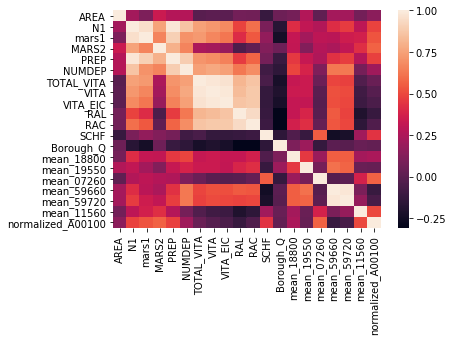

In [50]:
sns.heatmap(features.corr())

In [51]:
Xs = pd.concat((X_train,X_test))

In [52]:
ys = pd.concat((y_train,y_test))

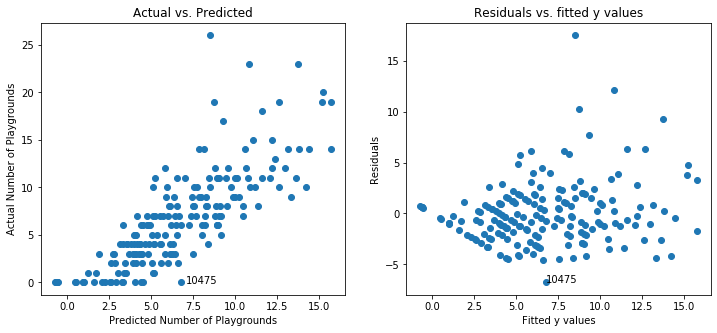

In [53]:
preds = pd.Series(EN.predict(Xs),index = Xs.index)

def plot_predictions(preds, Xs, ys):
    worst_zip = 10475
    fig, ax = plt.subplots(1,2, figsize=(12,5))

    ax[0].scatter(preds, ys)
    ax[0].annotate(worst_zip, (preds[worst_zip] + 0.3, ys[worst_zip]-0.2))
    ax[0].set_ylabel('Actual Number of Playgrounds')
    ax[0].set_xlabel('Predicted Number of Playgrounds')
    ax[0].set_title('Actual vs. Predicted')


    resids = ys - preds
    residdf = pd.concat((resids, preds),axis=1).rename(columns = {0:'resids', 1:'preds'})
    ax[1].scatter(residdf['preds'], residdf['resids'])
    ax[1].annotate(worst_zip, (preds[worst_zip], resids[worst_zip]))

    ax[1].set_ylabel('Residuals')
    ax[1].set_xlabel('Fitted y values')
    ax[1].set_title('Residuals vs. fitted y values')
    
plot_predictions(preds, Xs, ys)

Two important things to note here:
 
 1) 10475 has a lot less playgrounds than the model predicts. This could be a Zip Code that could benefit a lot from having more playgrounds
 
 2) The residuals plot should be normally distributed aound zero - there's some room for improvement here
 

### Diagnostic Plots

Using the features from ElasticNet to fit a non-regularized regression model to see if I can make any inferences

In [54]:
X_train2 = X_train.iloc[:,EN['elasticnet'].coef_.nonzero()[0]]
y_train2 = y_train.copy()

In [55]:
from statsmodels.graphics.gofplots import ProbPlot

def resid_v_fitted(fitted_y, y, ax):
    '''Plots the residuals vs. fitted yvalues'''
    sns.residplot(fitted_y, y,
          lowess=True, scatter_kws={'alpha': 0.5},
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},ax=ax)
                 
    ax.set_title('Residuals vs Fitted')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

def normal_QQ_plot(norm_residuals, ax):
    QQ = ProbPlot(norm_residuals)
    QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax=ax)
    ax.set_title('Normal Q-Q')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Standardized Residuals')
    abs_norm_resid =norm_residuals.sort_values(ascending=False)
     
    
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3.index):
        ax.annotate(i, xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                        norm_residuals[i]));

def scale_loc_plot(fitted_y, norm_residuals, norm_residuals_abs_sqrt, ax=ax):
    ax.scatter(fitted_y, norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(fitted_y, norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)
    ax.set_title('Scale-Location')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('$\sqrt{|Standardized Residuals|}$');

    # annotations
    abs_norm_resid = norm_residuals.sort_values(ascending=False)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    abs_sq_norm_resid = norm_residuals_abs_sqrt.sort_values(ascending=False)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
 
    for i in abs_norm_resid_top_3.index:
        ax.annotate(i, xy=(fitted_y[i],
                norm_residuals_abs_sqrt[i]))

def residuals_v_leverage_plot(norm_residuals, model_leverage,ax):
    ax.scatter(model_leverage, norm_residuals, alpha=0.5);
    sns.regplot(model_leverage, norm_residuals, scatter=False,
              ci=False, lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)
    
    ax.set_xlim(0, max(model_leverage)+0.01)
    ax.set_ylim(-3, 5)
    ax.set_title('Residuals vs Leverage')
    ax.set_xlabel('Leverage')
    ax.set_ylabel('Standardized Residuals')
    
        
def diagnostic_plots(model, X, y, return_high_leverage=False):
    fitted_y = model.fittedvalues
    residuals = model.resid
    norm_residuals = pd.Series(model.get_influence().resid_studentized_internal, index=fitted_y.index)
    norm_residuals_abs_sqrt = pd.Series(np.sqrt(np.abs(norm_residuals)), index=fitted_y.index)
    model_abs_resid = pd.Series(np.abs(residuals), index=fitted_y.index)
    model_leverage = pd.Series(model.get_influence().hat_matrix_diag, index=fitted_y.index)
    avg_leverage = model_leverage.mean()
    model_cooks = pd.Series(model.get_influence().cooks_distance[0], index=fitted_y.index)
    fig, ax = plt.subplots(2,2, figsize=(12,10))
    # Residuals vs. Fitted
    resid_v_fitted(fitted_y, y, ax=ax[0,0])
    # Normal QQ Plot
    normal_QQ_plot(norm_residuals, ax=ax[0,1])
    # Scale-Location
    scale_loc_plot(fitted_y, norm_residuals, norm_residuals_abs_sqrt, ax=ax[1,0])
    # Residuals vs. Leverage
    residuals_v_leverage_plot(norm_residuals, model_leverage,ax=ax[1,1])
    if return_high_leverage:
        return model_leverage[model_leverage > avg_leverage*2]
    

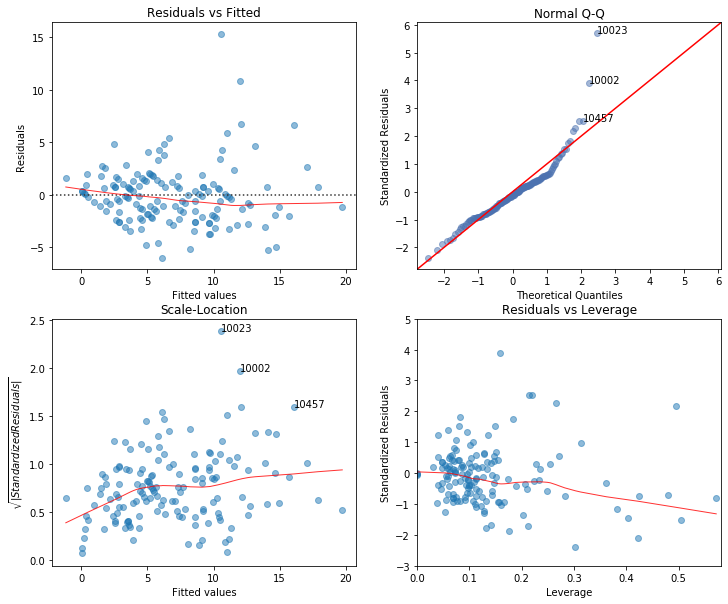

In [56]:
mod = sm.OLS(y_train2, X_train2)
res = mod.fit()
lev_pts = diagnostic_plots(res, X_train2, y_train2, return_high_leverage=True)

There looks to be a slight trend in the residuals here, and some high leverage points that could be throwing off the model

A common rule of thumb for removing high leverage points is removing observations with leverage greater than 2x the average leverage. I have built a feature into the diagnostic plot function to return these high leverage points

In [57]:
y_train2 = y_train2[~y_train2.isin(lev_pts.index)]
X_train2 = X_train2[~X_train2.isin(lev_pts.index)]

# Feature Engineering: Improving the model with log transforms and polynomial transforms, using the features found from the Elastic Net

I'm going to do some manual feature engineering to make the X variables have a normal distribution, which should reduce some heteroscedasticity in the residual plot. It will also be nice to see if some of these features can be thrown away to reduce bias, or if some have non-linear relationships to the dependent variable which could improve the model further.

In [58]:
X_train2.shape

(148, 20)

In [59]:
log_features = []
poly1_features = []
poly2_features = []
poly3_features = []
sqrt_features = []

bool_features = []
drop_features = []

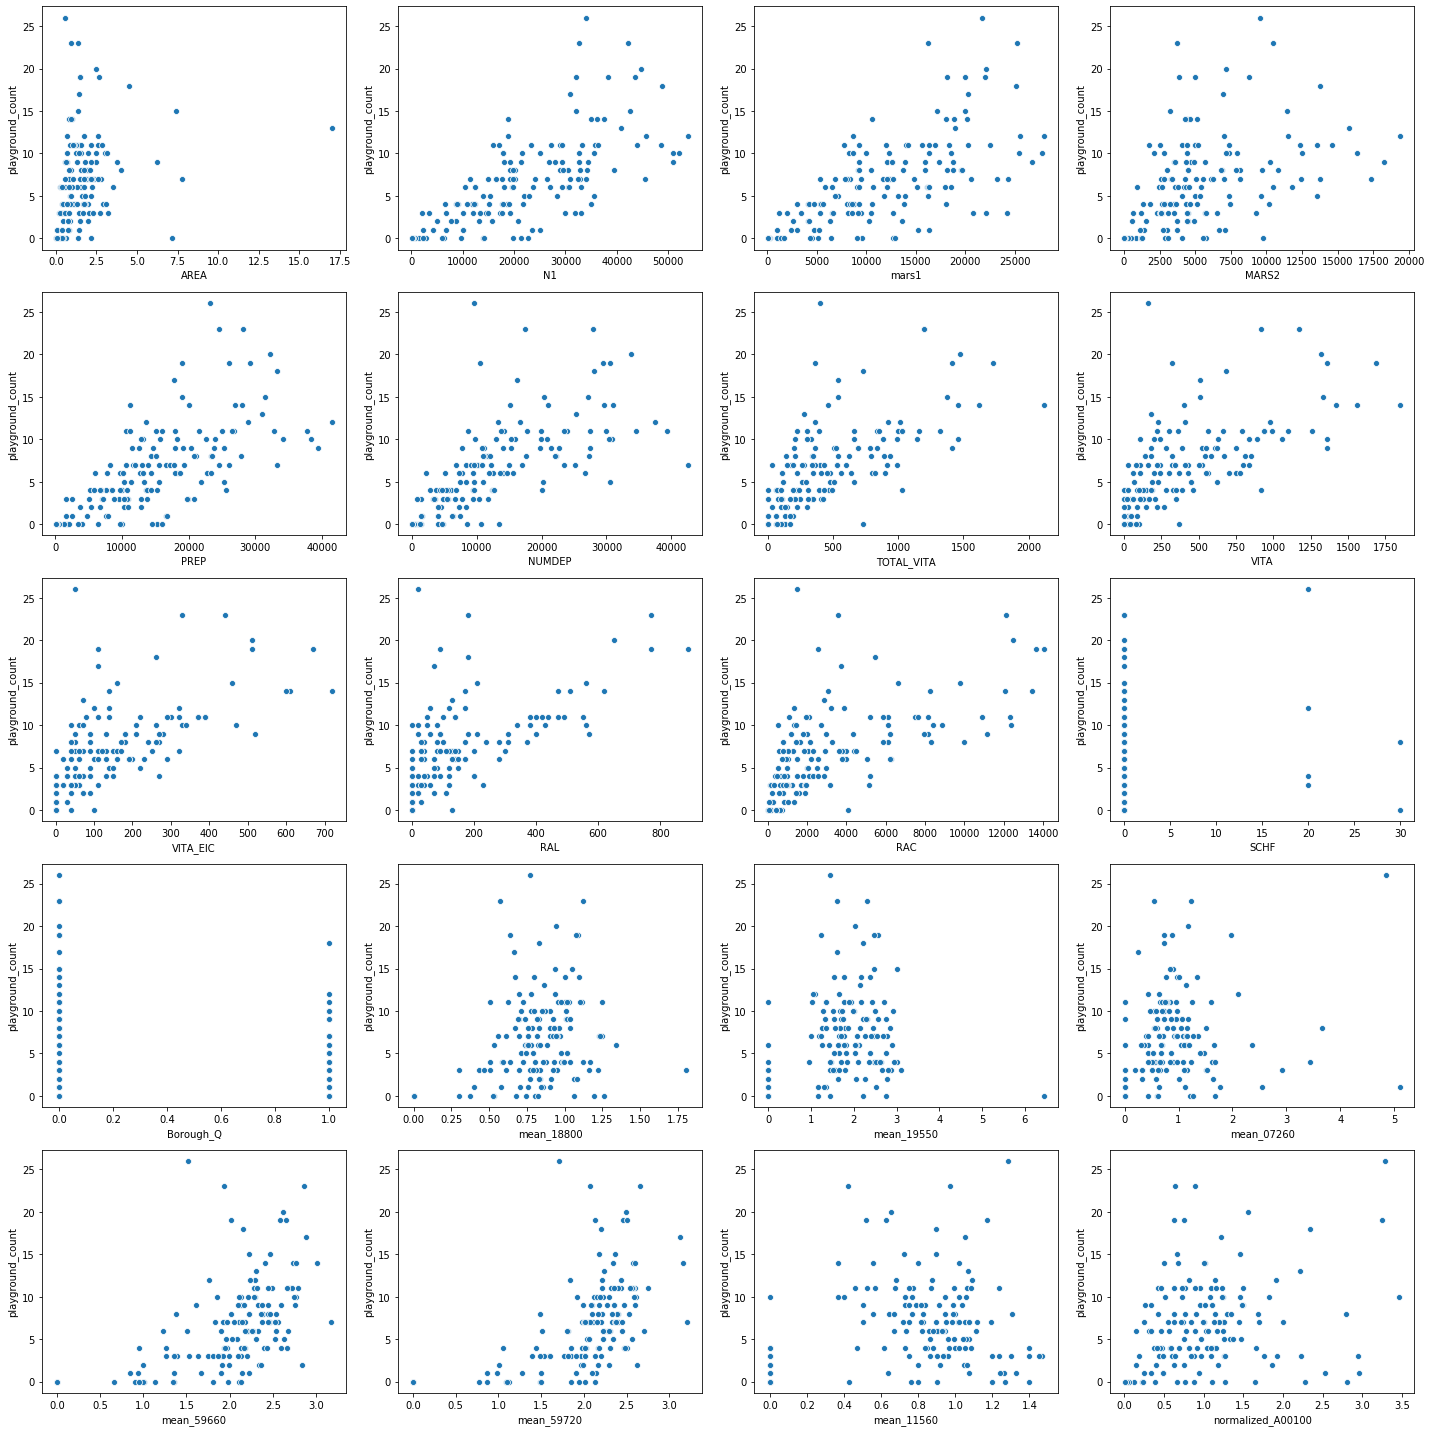

In [60]:
fig, ax = plt.subplots(5,4, figsize = (20,20))

col_idx = -1
for i in range(5):
    for j in range(4):
        col_idx += 1
        sns.scatterplot(features[features.columns[col_idx]], y_train, ax=ax[i, j])
plt.tight_layout()

In [61]:
from sklearn.preprocessing import PolynomialFeatures
def plot_feature(X_train, y_train, col, bins=10):
    fig, ax = plt.subplots(1,2, figsize=(12,2))
    ax[0].scatter(X_train[[col]], y_train)
    ax[1].hist(X_train[col], bins=bins)

In [62]:
def log_transform(series, inverse=False):
    if inverse:
        return np.exp(series)-0.1
    return np.log(series+0.1)

In [63]:
X_train2.columns

Index(['AREA', 'N1', 'mars1', 'MARS2', 'PREP', 'NUMDEP', 'TOTAL_VITA', 'VITA',
       'VITA_EIC', 'RAL', 'RAC', 'SCHF', 'Borough_Q', 'mean_18800',
       'mean_19550', 'mean_07260', 'mean_59660', 'mean_59720', 'mean_11560',
       'normalized_A00100'],
      dtype='object')

## Area

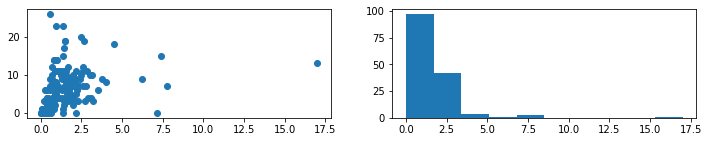

In [64]:
plot_feature(X_train2, y_train2, 'AREA')

In [65]:
log_features.append('AREA')

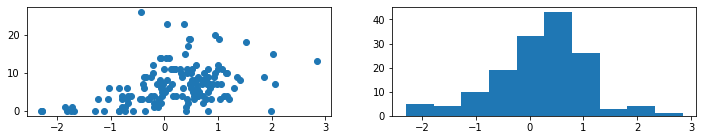

In [66]:
plot_feature(log_transform(X_train2), y_train2, 'AREA')

In [67]:
def search_poly_grid(X, y):
    degrees = [1,2,3]
    scores = []
    for degree in degrees:
        LR_clf = make_pipeline(PolynomialFeatures(degree), StandardScaler(), LinearRegression())
        LR_cv_score = (cross_val_score(LR_clf, X, y, cv=10, scoring = 'r2')).mean()
        scores.append(LR_cv_score)
    print(scores)
    return degrees[np.argmax(scores)]
    

In [68]:
search_poly_grid(log_transform(X_train2[['AREA']]), y_train2)

[0.1401843968236158, 0.13838390923330118, 0.11290810186650013]


1

# N1

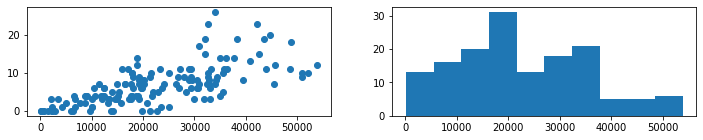

In [69]:
plot_feature(X_train2, y_train2, 'N1')

In [70]:
search_poly_grid(X_train2[['N1']], y_train2)

[0.4345168402039075, 0.44054978904793873, 0.4375699321569503]


2

This feature looks good as is. Cross validating shows decent fit for 1-3 degree polynomial features, so in this case it's best to keep it simple

In [71]:
poly1_features.append('N1')

# MARS1

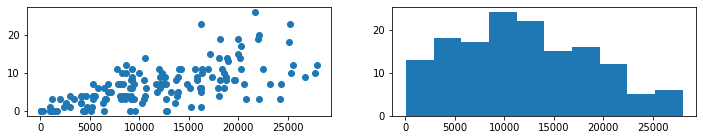

In [72]:
plot_feature(X_train2, y_train2, 'mars1')

In [73]:
search_poly_grid(X_train2[['mars1']], y_train2)

[0.37787698425621313, 0.384259839556247, 0.37673533326937586]


2

This feature looks good as is. Cross validating shows decent fit for 1-3 degree polynomial features, so in this case it's best to keep it simple

In [74]:
poly1_features.append('mars1')

# MARS2

In [75]:
X_train.columns[3]

'MARS2'

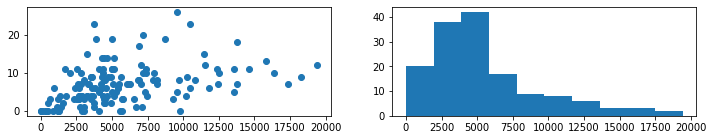

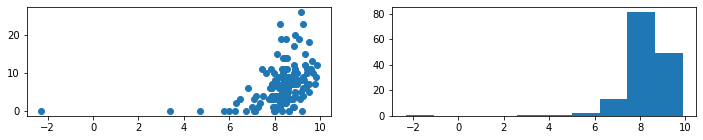

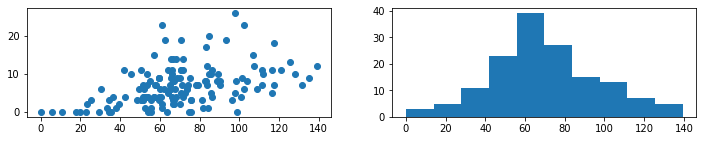

In [76]:
plot_feature(X_train2, y_train2, 'MARS2')
plot_feature(log_transform(X_train2), y_train2, 'MARS2')
plot_feature(np.sqrt(X_train2), y_train2, 'MARS2')

In [77]:
search_poly_grid(np.sqrt(X_train2[['MARS2']]), y_train2)

[0.12778439160900104, 0.14731996299386801, 0.13429274967002378]


2

A $\sqrt{x}$ transform creates a normal distribution, is the best transform in this case (very normal looking distribution)

In [78]:
sqrt_features.append('MARS2')

# PREP

In [79]:
X_train2.columns[4]

'PREP'

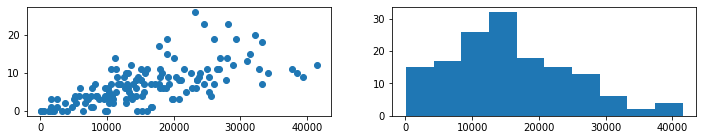

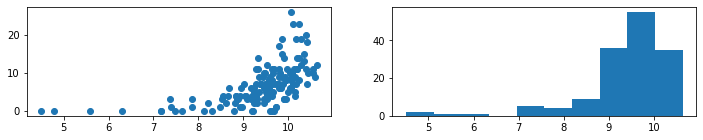

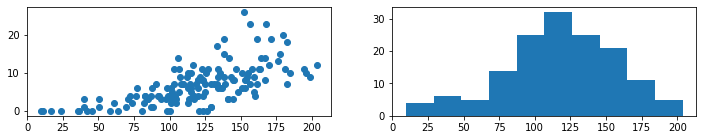

In [80]:
plot_feature(X_train2, y_train2, 'PREP')
plot_feature(log_transform(X_train2), y_train2, 'PREP')
plot_feature(np.sqrt(X_train2), y_train2, 'PREP')

In [81]:
search_poly_grid(np.sqrt(X_train2[['PREP']]), y_train2)

[0.4015001860629305, 0.3936813819418347, 0.40677600698043975]


3

In [82]:
sqrt_features.append('PREP')

# NUMDEP

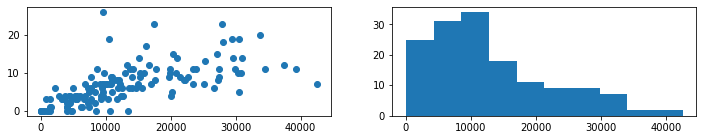

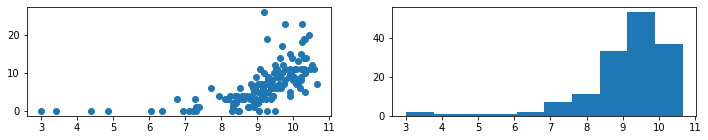

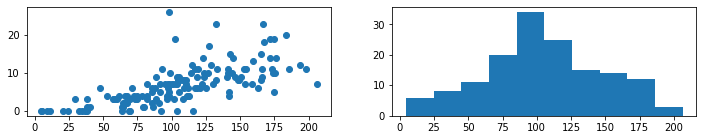

In [83]:
plot_feature(X_train2, y_train2, 'NUMDEP')
plot_feature(log_transform(X_train2), y_train2, 'NUMDEP')
plot_feature(np.sqrt(X_train2), y_train2, 'NUMDEP')

In [84]:
search_poly_grid(np.sqrt(X_train2[['NUMDEP']]), y_train2)

[0.44761511783362734, 0.4438823000474673, 0.450912663367239]


3

In [85]:
sqrt_features.append('NUMDEP')

# TOTAL_VITA

In [86]:
X_train2.columns[6]

'TOTAL_VITA'

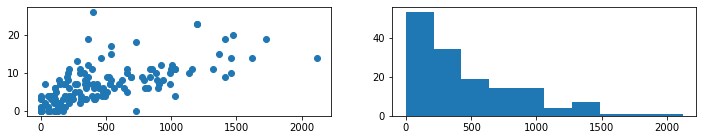

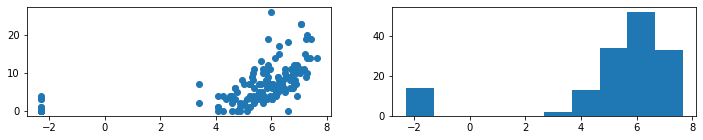

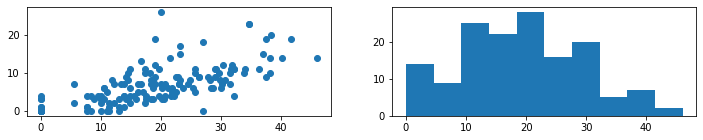

In [87]:
plot_feature(X_train2, y_train2, 'TOTAL_VITA')
plot_feature(log_transform(X_train2), y_train2, 'TOTAL_VITA')
plot_feature(np.sqrt(X_train2), y_train2, 'TOTAL_VITA')

In [88]:
search_poly_grid(np.sqrt(X_train2[['TOTAL_VITA']]), y_train2)

[0.46529990171663105, 0.4623731548755103, 0.4561740365887621]


1

In [89]:
poly1_features.append('TOTAL_VITA')

# VITA

In [90]:
X_train2.columns[7]

'VITA'

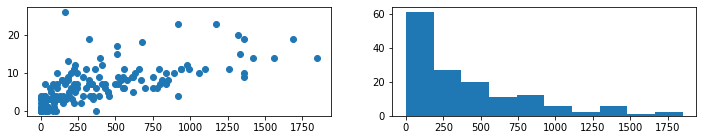

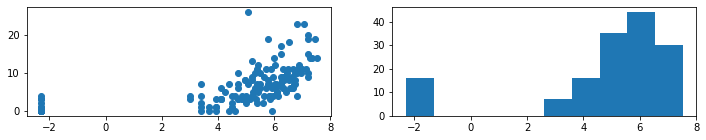

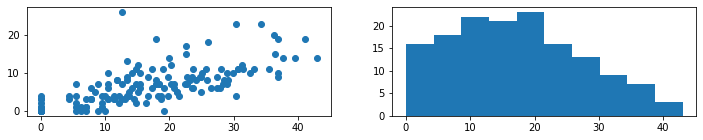

In [91]:
plot_feature(X_train2, y_train2, 'VITA')
plot_feature(log_transform(X_train2), y_train2, 'VITA')
plot_feature(np.sqrt(X_train2), y_train2, 'VITA')

In [92]:
search_poly_grid(np.sqrt(X_train2[['VITA']]), y_train2)

[0.4708405766884932, 0.4676221681900291, 0.4677276463559819]


1

In [93]:
sqrt_features.append('VITA')

# VITA_EIC

In [94]:
X_train2.columns[8]

'VITA_EIC'

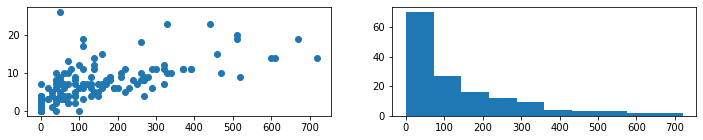

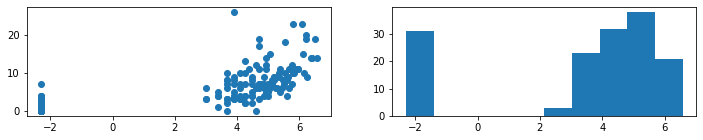

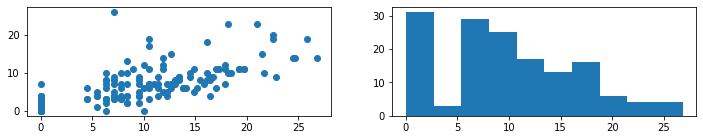

In [95]:
plot_feature(X_train2, y_train2, 'VITA_EIC')
plot_feature(log_transform(X_train2), y_train2, 'VITA_EIC')
plot_feature(np.sqrt(X_train2), y_train2, 'VITA_EIC')

In [96]:
search_poly_grid(np.sqrt(X_train2[['VITA_EIC']]), y_train2)

[0.4990698547459599, 0.4950117682266755, 0.49212610405335583]


1

In [97]:
y_train2.groupby([X_train2.VITA_EIC == 0]).mean()

VITA_EIC
False    8.205128
True     1.419355
Name: playground_count, dtype: float64

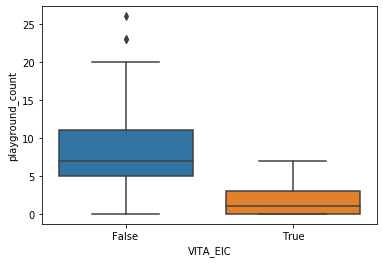

In [98]:
sns.boxplot((X_train2.VITA_EIC == 0), y_train2)

Should add a boolean to represent zero-values VITA-EICs, since those areas seem to have much less playgrounds. 

`VITA_EIC`: _Number of volunteer prepared returns with Earned Income Credit_

In [99]:
sqrt_features.append('VITA_EIC')

# RAL

In [100]:
X_train2.columns[9]

'RAL'

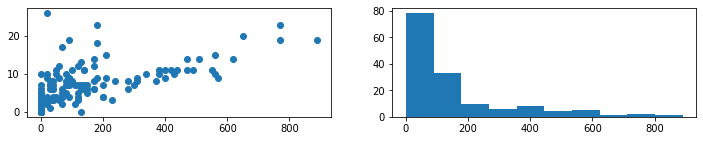

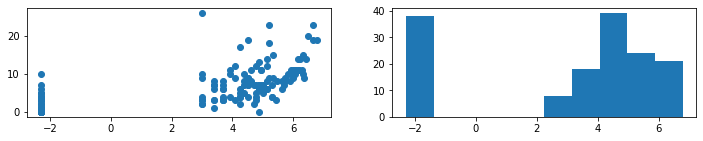

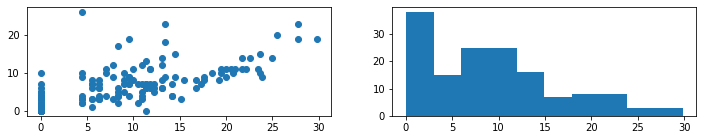

In [101]:
plot_feature(X_train2, y_train2, 'RAL')
plot_feature(log_transform(X_train2), y_train2, 'RAL')
plot_feature(np.sqrt(X_train2), y_train2, 'RAL')

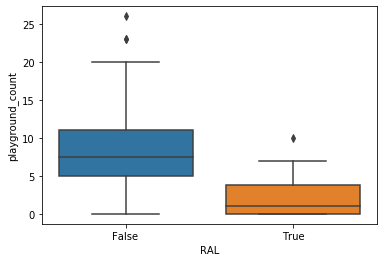

In [102]:
sns.boxplot((X_train2.RAL == 0), y_train2)

In [103]:
search_poly_grid(np.sqrt(X_train2[['RAL']]), y_train2)

[0.42939936888630237, 0.41735328751626427, 0.43784838970266887]


3

In [104]:
sqrt_features.append('RAL')

# RAC

In [105]:
X_train2.columns[10]

'RAC'

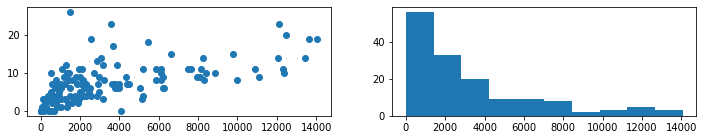

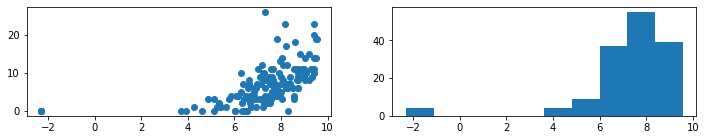

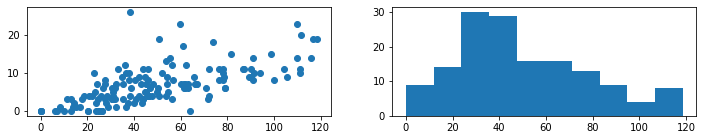

In [106]:
plot_feature(X_train2, y_train2, 'RAC')
plot_feature(log_transform(X_train2), y_train2, 'RAC')
plot_feature(np.sqrt(X_train2), y_train2, 'RAC')

In [107]:
search_poly_grid(np.sqrt(X_train2[['RAC']]), y_train2)

[0.42737625772541, 0.42280388866119145, 0.43512207363824346]


3

In [108]:
poly1_features.append('RAC')

# SCHF

In [109]:
X_train2.columns[11]

'SCHF'

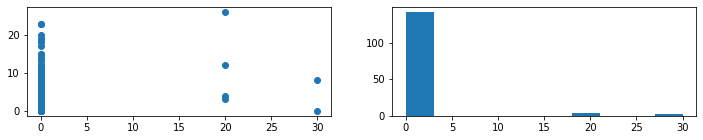

In [110]:
plot_feature(X_train2, y_train2, 'SCHF')

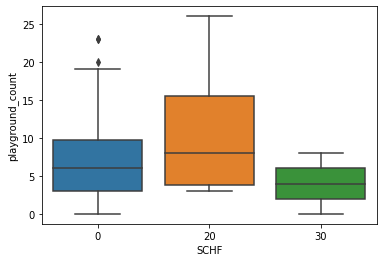

In [111]:
sns.boxplot(X_train2['SCHF'], y_train2)

For reference, SCHF is number of farm returns. There's very little information in this feature given the count of nonzero values

In [112]:
drop_features.append('SCHF')

# Borough_Q

In [113]:
X_train2.columns[12]

'Borough_Q'

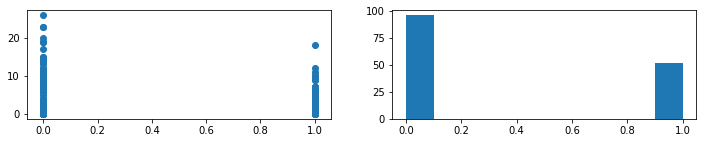

In [114]:
plot_feature(X_train2, y_train2, 'Borough_Q')

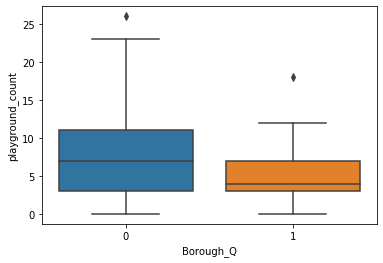

In [115]:
sns.boxplot(X_train2['Borough_Q'], y_train2)

In [116]:
bool_features.append('Borough_Q')

# mean_18800

In [117]:
X_train2.columns[13]

'mean_18800'

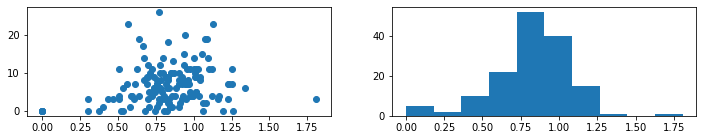

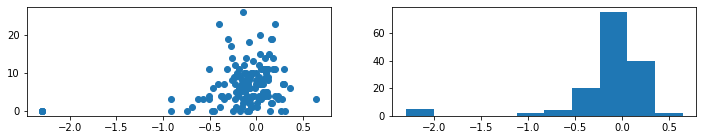

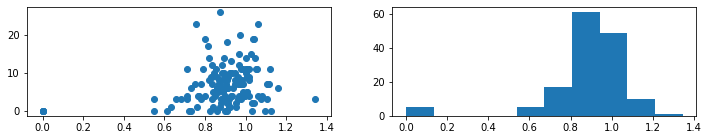

In [118]:
plot_feature(X_train2, y_train2, 'mean_18800')
plot_feature(log_transform(X_train2), y_train2, 'mean_18800')
plot_feature(np.sqrt(X_train2), y_train2, 'mean_18800')

In [119]:
search_poly_grid(X_train2[['mean_18800']], y_train2)

[-0.03577541746049949, 0.0399209993867118, -0.02902773388830977]


2

In [120]:
poly2_features.append('mean_18800')

# mean_19550

In [121]:
X_train2.columns[14]

'mean_19550'

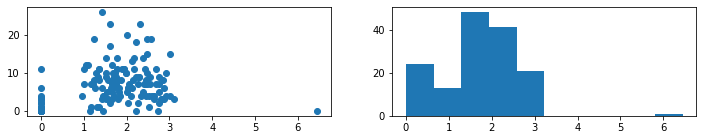

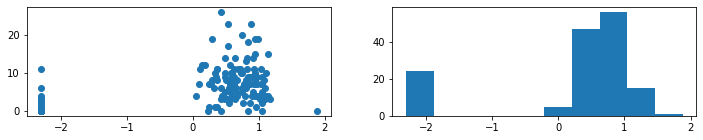

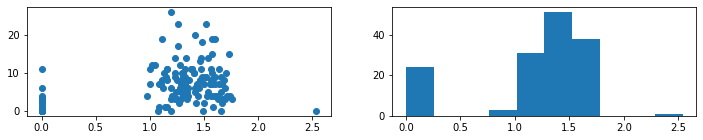

In [122]:
plot_feature(X_train2, y_train2, 'mean_19550')
plot_feature(log_transform(X_train2), y_train2, 'mean_19550')
plot_feature(np.sqrt(X_train2), y_train2, 'mean_19550')

In [123]:
search_poly_grid(X_train2[['mean_19550']], y_train2)

[-0.005850010764491676, -0.03700983803754524, -0.961410950227022]


1

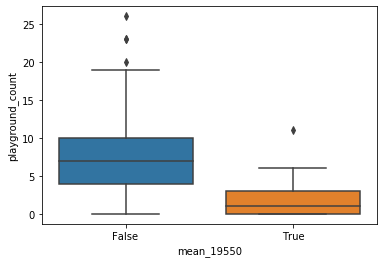

In [124]:
sns.boxplot((X_train2['mean_19550'] == 0), y_train2)

`mean_19550`: Qualified Mortgage Insurance premiums amount

In [125]:
bool_features.append('mean_19550')

# mean_07260

In [126]:
X_train2.columns[15]

'mean_07260'

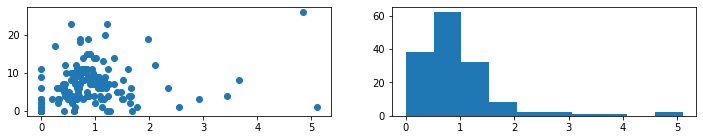

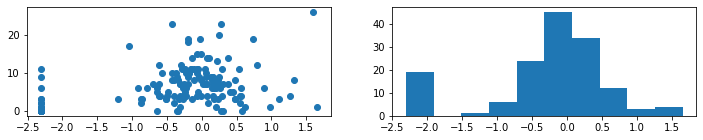

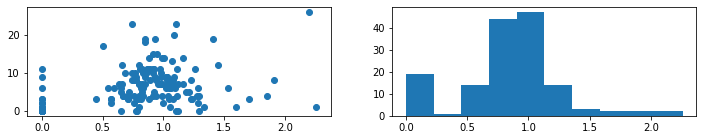

In [127]:
plot_feature(X_train2, y_train2, 'mean_07260')
plot_feature(log_transform(X_train2), y_train2, 'mean_07260')
plot_feature(np.sqrt(X_train2), y_train2, 'mean_07260')

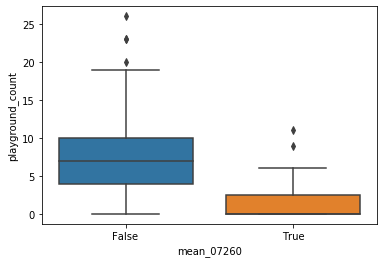

In [128]:
sns.boxplot((X_train2['mean_07260'] == 0), y_train2)

In [129]:
search_poly_grid(log_transform(X_train2[['mean_07260']]), y_train2)

[0.021937243353789347, 0.013309881899231435, -0.047199197902410076]


1

In [130]:
bool_features.append('mean_07260')

# mean_59660

In [131]:
X_train2.columns[16]

'mean_59660'

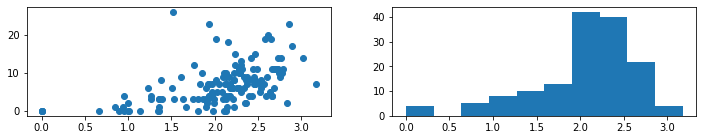

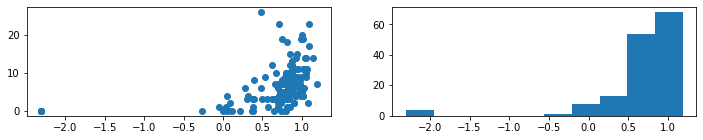

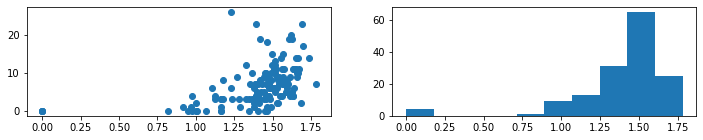

In [132]:
plot_feature(X_train2, y_train2, 'mean_59660')
plot_feature(log_transform(X_train2), y_train2, 'mean_59660')
plot_feature(np.sqrt(X_train2), y_train2, 'mean_59660')

In [133]:
search_poly_grid(X_train2[['mean_59660']], y_train2)

[0.23111051109704386, 0.22784546967961247, 0.2178160227227556]


1

In [134]:
poly1_features.append('mean_59660')

# mean_59720

In [135]:
X_train2.columns[17]

'mean_59720'

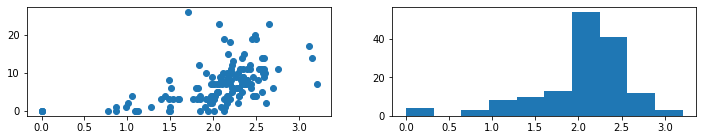

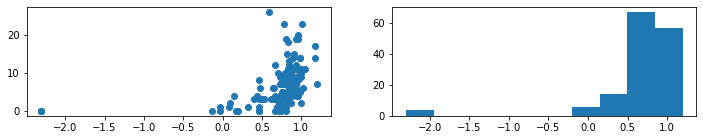

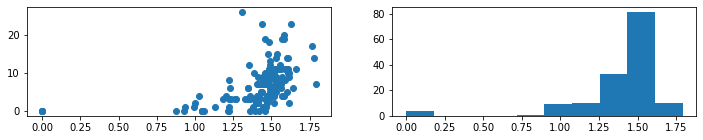

In [136]:
plot_feature(X_train2, y_train2, 'mean_59720')
plot_feature(log_transform(X_train2), y_train2, 'mean_59720')
plot_feature(np.sqrt(X_train2), y_train2, 'mean_59720')

In [137]:
search_poly_grid(X_train2[['mean_59720']], y_train2)

[0.26085184779994053, 0.2680259231007796, 0.2598465122930595]


2

In [138]:
poly1_features.append('mean_59720')

# mean_11560

In [139]:
X_train2.columns[18]

'mean_11560'

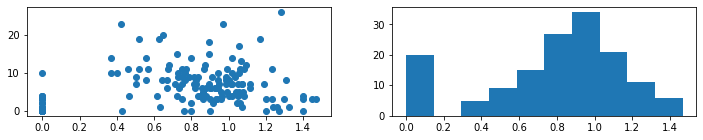

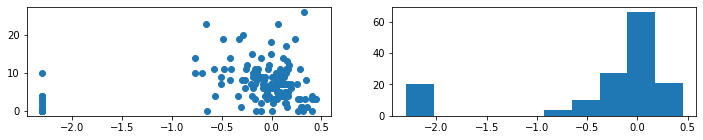

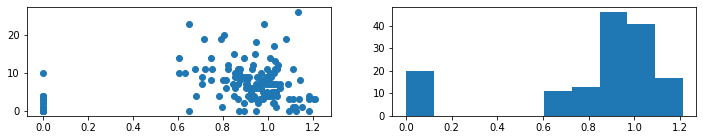

In [140]:
plot_feature(X_train2, y_train2, 'mean_11560')
plot_feature(log_transform(X_train2), y_train2, 'mean_11560')
plot_feature(np.sqrt(X_train2), y_train2, 'mean_11560')

In [141]:
search_poly_grid(X_train2[['mean_11560']][X_train2.mean_11560 !=0], y_train2[X_train2.mean_11560 !=0])

[0.024128325629627034, 0.020274988335751965, 0.018349653044678747]


1

In [142]:
bool_features.append('mean_11560')

# normalized_A00100

In [143]:
X_train2.columns[19]

'normalized_A00100'

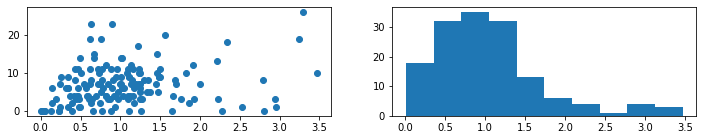

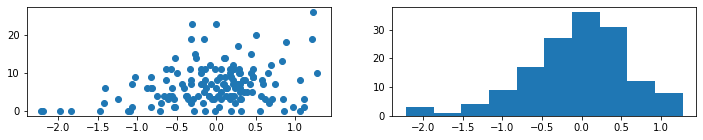

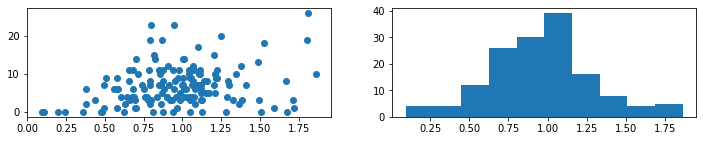

In [144]:
plot_feature(X_train2, y_train2, 'normalized_A00100')
plot_feature(log_transform(X_train2), y_train2, 'normalized_A00100')
plot_feature(np.sqrt(X_train2), y_train2, 'normalized_A00100')

In [145]:
search_poly_grid(np.sqrt(X_train2[['normalized_A00100']]), y_train2)

[-0.027224613489246364, -0.02834936131237087, -0.017115727869663467]


3

I'm not so sure this feature is important, interestingly enough. Will drop this

In [146]:
drop_features.append('normalized_A00100')

# Making the Transformation

In [147]:
print(bool_features)
print(drop_features)

 
print(sqrt_features)
print(log_features)

print(poly1_features)
print(poly2_features)
print(poly3_features)

['Borough_Q', 'mean_19550', 'mean_07260', 'mean_11560']
['SCHF', 'normalized_A00100']
['MARS2', 'PREP', 'NUMDEP', 'VITA', 'VITA_EIC', 'RAL']
['AREA']
['N1', 'mars1', 'TOTAL_VITA', 'RAC', 'mean_59660', 'mean_59720']
['mean_18800']
[]


In [148]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropLeverage(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X.columns:
            X[col] = (X[col] != 0)*1
        return X     

class BooleanAttributes(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X.columns:
            X[col] = (X[col] != 0)*1
        return X      

In [149]:
class DegreePolynomials(BaseEstimator, TransformerMixin):
    def __init__(self, sqrt_features=False, log_features=False, poly1=False, poly2=False):
        self.sqrt_features = sqrt_features
        self.log_features = log_features
        self.poly1 = poly1
        self.poly2 = poly2
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.sqrt_features:
            X = np.sqrt(X)
            return X
        elif self.log_features:
            X = log_transform(X)
            return X
        elif self.poly1:
            return X
        elif self.poly2:
            PN = PolynomialFeatures(degree=2, include_bias=False)
            poly2s = PN.fit_transform(X)
            return poly2s
        else:
            return X



In [150]:
from sklearn.compose import ColumnTransformer

In [151]:
numTransformer = ColumnTransformer([
    ('sqrt', DegreePolynomials(sqrt_features=True), sqrt_features),
    ('log', DegreePolynomials(log_features=True), log_features),
    ('poly1', DegreePolynomials(poly1=True), poly1_features),
    ('poly2', DegreePolynomials(poly2=True), poly2_features),
    
])

boolTransformer = ColumnTransformer([
    ('bool', BooleanAttributes(), bool_features)
])

cat_pipeline = Pipeline([
    ('bool', boolTransformer)
])

num_pipeline = Pipeline([
    ('num', numTransformer),
    ('scaler', StandardScaler())
])

num_features = sqrt_features + log_features + poly1_features + poly2_features
full_pipeline = ColumnTransformer([
    ('cat', cat_pipeline, bool_features),
    ('num', num_pipeline, num_features)
])


In [152]:
EN2 = make_pipeline(full_pipeline, ElasticNet(0.5))
EN2_score = (cross_val_score(EN2, X_train, y_train, 
            cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
print('Cross Val MAE', round(EN2_score,2))

EN2.fit(X_train, y_train)

print('Elastic Net regression MAE on test set: {}'.format(
    MAE(EN2.predict(X_test),y_test)))

print('Elastic regression R^2 on test set: {}'.format(
    EN2.score(X_test,y_test)))


Cross Val MAE 2.37
Elastic Net regression MAE on test set: 2.1631623659433536
Elastic regression R^2 on test set: 0.6799445542787519


In [153]:
chosen_features = set(X_train2.columns[np.nonzero(EN2['elasticnet'].coef_)[0]])

# Tuning Elastic Net

In [165]:
EN2 = make_pipeline(full_pipeline, ElasticNet())
EN2['elasticnet']

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Best a: 0.01, Best r parameter: 0.01, Best MAE score: 2.2181


Text(0, 0.5, 'Cross Val MAE Score')

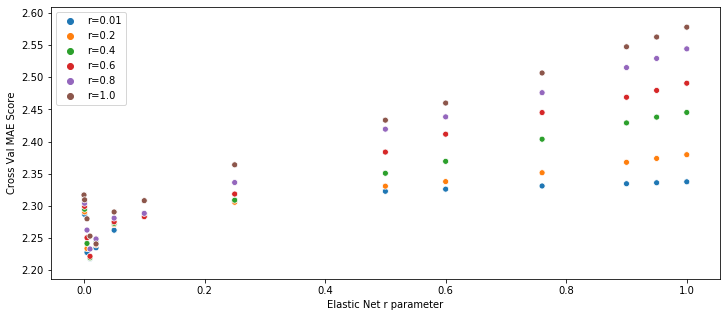

In [207]:
res = []
for alpha in [0, 0.00001, 0.001, 0.005, 0.01, 0.02,  0.05, 0.1, 0.25,  0.5, 0.6, 0.76, 0.9, 0.95, 1]:
    for l1 in [0.01, 0.2, 0.4,0.6, 0.8, 1]:
        EN2 = make_pipeline(full_pipeline, ElasticNet(alpha=alpha, l1_ratio=l1))
        EN2_score = (cross_val_score(EN2, X_train, y_train, 
                    cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
        res.append([alpha, l1, round(EN2_score,4)])

res = np.array(res)

fig, ax = plt.subplots(1,1,figsize=(12,5))
r_params = np.char.array(np.full(res.shape[0],'r=')) +  np.char.array(np.around(res[:,1],2).astype(str))
sns.scatterplot(res[:,0], res[:,2], hue = r_params, ax=ax)

min_error = res[ res[:,2]==res[:,2].min() ]
print('Best a: {}, Best r parameter: {}, Best MAE score: {}'.format(
    min_error[0][0], min_error[0][1], min_error[0][2]))

plt.xlabel('Elastic Net r parameter')
plt.ylabel('Cross Val MAE Score')

# Final Prediction

After a lot of tuning, These are the final results of the model. As a summary:
 - ElasticNet was used for feature selection
 - Log(x), $\sqrt{x}$, and polynomial(i=1,i=2) transforms were performed. Decisions were made strictly based on the training set
 - The r parameter for the final ElasticNet model was fine tuned based on cross validation scores
 - Predictions were made on a holdout set

In [183]:
EN2 = make_pipeline(full_pipeline, ElasticNet(0.01, 0.01))
EN2_score = (cross_val_score(EN2, X_train, y_train, 
            cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
print('Cross Val MAE', round(EN2_score,2))

EN2.fit(X_train, y_train)
print('ElasticNet regression MAE on test set: {}'.format(
    MAE(EN2.predict(X_test),y_test.values)))

print('ElasticNet regression R^2 on test set: {}'.format(
    EN2.score(X_test,y_test)))


Cross Val MAE 2.22
ElasticNet regression MAE on test set: 2.130441388973058
ElasticNet regression R^2 on test set: 0.7280494953205872


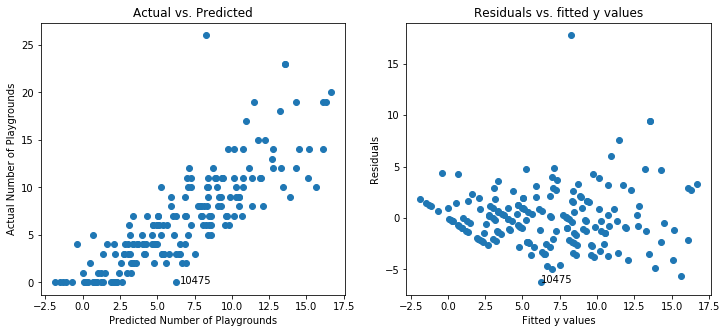

In [156]:
preds = pd.Series(EN2.predict(Xs),index = Xs.index)
plot_predictions(preds,Xs, ys)

The final model resulted in a __Cross Validated (k=10) Mean Absolute Error of 2.22__ on the training set and a __Mean Absolute Error of 2.17__ and an __$R^2$ of 0.72__ on the test set. The manual feature engineering and parameter tuning was intensive, and only resulted in a marginal increase in predictive ability, however it certainly did make a difference. 

Comparing the original model to the final model, the Residuals vs. Fitted plot looks much less heteroscedastic. If anything, a weighted least squares could be attempted to correct for heteroscedasticity even further, however that would likely have little impact on prediction, and moreso impact the error estimates.

# Findings

I'm happy to call this project complete, with Zip Code 10475 being a great location for intervention.

It was particularly interesting to see that `EIC` (mean_59660), which is typically given to low income families with children, was a really good predictor for the number of playgrounds. I wouldn't be surprised if NYC takes EIC directly into account when making resourcce allocation decisions for playgrounds

The final list of predictors is below

In [157]:
results = zip(X_train2.columns[np.nonzero(EN2['elasticnet'].coef_)[0]], EN2['elasticnet'].coef_[np.nonzero(EN2['elasticnet'].coef_)[0]])
best_features = pd.DataFrame(results, columns = ['Feature', 'Coef (Post transform)'])
best_features.set_index('Feature', inplace=True)
best_features

,Coef (Post transform)
Feature,
AREA,-0.429691
N1,-0.072032
mars1,-0.506689
MARS2,0.247039
PREP,4.645798
NUMDEP,-1.556358
TOTAL_VITA,-2.875925
VITA,-1.897568
VITA_EIC,1.556840


It's important to note that the scale of the coefficients above were changed through the log, sqrt, and polynomial transformations, as well as the Standardization. More importantly, since regularized regression was used, these are *biased estimators* making them less interpretable than a typical linear regression Beta coefficient, however they're still useful for quick reference of magnitude and direction!

## A quick look at EIC

As a quick reminder, Regularized regression introduces bias, so its beta coefficients are [biased estimators](https://stats.stackexchange.com/questions/207760/when-is-a-biased-estimator-preferable-to-unbiased-one)

I will fit a simple 1 variable linear regression mode, since it is the Best Linear Unbiased Estimator in this scenario.

As the __Total Earned Income Credit Amount normalized by the number of returns with EIC__, `mean_59660`, increases by 1, the number of playgrounds increases by 4.17.  

In [158]:
sm.OLS(y, sm.add_constant( X['mean_59660'] - X['mean_59660'].mean() )).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       playground_count   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     57.68
Date:                Mon, 06 Jan 2020   Prob (F-statistic):           1.50e-12
Time:                        17:13:21   Log-Likelihood:                -543.05
No. Observations:                 186   AIC:                             1090.
Df Residuals:                     184   BIC:                             1097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7366      0.331     20.375      0.000       6.084       7.389
mean_59660     4.1712      0.549      7.595      0.000       3.088       5.255
==============================================================================
Omnibus:                       54.655   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.355
Skew:                           1.288   Prob(JB):                     3.00e-29
Kurtosis:                       6.212   Cond. No.                         1.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [159]:
sm.OLS(df_original['playground_count'], sm.add_constant( df_original['A59660']/1000 - (df_original['A59660']/1000).mean() )).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       playground_count   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     129.7
Date:                Mon, 06 Jan 2020   Prob (F-statistic):           4.36e-23
Time:                        17:13:21   Log-Likelihood:                -518.80
No. Observations:                 186   AIC:                             1042.
Df Residuals:                     184   BIC:                             1048.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7366      0.290     23.213      0.000       6.164       7.309
A59660         0.2594      0.023     11.389      0.000       0.214       0.304
==============================================================================
Omnibus:                       76.664   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.198
Skew:                           1.609   Prob(JB):                     5.85e-64
Kurtosis:                       8.217   Cond. No.                         12.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

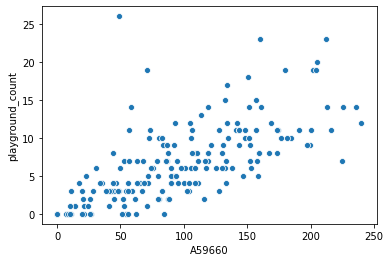

In [160]:
sns.scatterplot(np.sqrt(df_original['A59660']), df_original['playground_count'])